In [1]:
%env DDE_BACKEND=tensorflow

env: DDE_BACKEND=tensorflow


In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import deepxde as dde
import numpy as np
SEED = 0xdde
dde.config.set_random_seed(SEED)
def f1(x):
    return x * np.sin(5 * x)
def get_gradients_of_weights(model16):
    x_train = model16.data.train_x
    y_train = model16.data.train_y
    with tf.GradientTape() as tape:
        y_pred = model16.net.call(x_train)
        loss_fn = dde.losses.get("MSE")
        loss = loss_fn(y_train, y_pred)
    gradients16 = tape.gradient(loss,model16.net.trainable_weights)
    gradients161d = np.concatenate([gradient.numpy().ravel() for gradient in gradients16])
    return gradients161d
def get_weights(model16):
    return np.concatenate([weight.flatten() for weight in model16.net.get_weights()])
def cos_sim_and_dist_of_vectors(g16, g32):
    def cosine_similarity(vector1, vector2):
        dot_product = np.dot(vector1, vector2)
        norm_vector1 = np.linalg.norm(vector1)
        norm_vector2 = np.linalg.norm(vector2)
        return dot_product / (norm_vector1 * norm_vector2)
    csim = cosine_similarity(g16, g32)
    dist = np.linalg.norm(g16 - g32)

    return csim, dist

class SaveGradientsCallback(dde.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.list_of_weights = []
    def on_epoch_begin(self):
        weights = get_weights(self.model)
        grads = get_gradients_of_weights(self.model)
#         print(np.array(weights).shape, np.array(grads).shape)
        self.list_of_weights.append((weights, grads))

#
# Create the original model as float32
#
dde.config.set_default_float('float32')

geom = dde.geometry.Interval(-1, 1)
data = dde.data.Function(geom, f1, 16, 100)

net = dde.nn.FNN([1] + [10] * 2 + [1], "tanh", "Glorot uniform")
model32 = dde.Model(data, net)
model32.compile("adam", lr=0.001, metrics=["l2 relative error"])
model32.train(iterations=0)

#
# create a new model, but float16
#
dde.config.set_default_float('float16')

geom = dde.geometry.Interval(-1, 1)
data = dde.data.Function(geom, f1, 16, 100)

net = dde.nn.FNN([1] + [10] * 2 + [1], "tanh", "Glorot uniform")
model16 = dde.Model(data, net)
model16.compile("adam", lr=0.001, metrics=["l2 relative error"])
model16.train(iterations=0)
#
# copy the weights over
#
print(model32.net.__dict__)
for i, layer in enumerate(model32.net.denses):
    model16.net.denses[i].set_weights(
        [tf.cast(w, dtype=tf.float16) for w in layer.get_weights()]
    )
#
# train the models
#
dde.config.set_default_float('float32')
cback32 = SaveGradientsCallback()
losshistory, train_state = model32.train(iterations=10_000,
                                         callbacks=[cback32]
)
dde.config.set_default_float('float16')
cback16 = SaveGradientsCallback()
losshistory, train_state = model16.train(iterations=10_000,callbacks=[cback16])

2024-01-04 19:24:49.758923: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
Using backend: tensorflow
Other supported backends: tensorflow.compat.v1, pytorch, jax, paddle.
paddle supports more examples now and is recommended.


Set the default float type to float32
Compiling model...
'compile' took 0.007781 s

Training model...



/Users/Jeniffer/Documents/mixed-precision-sciml/venv/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


Step      Train loss    Test loss     Test metric   
0         [2.57e-01]    [2.19e-01]    [1.02e+00]    

Best model at step 0:
  train loss: 2.57e-01
  test loss: 2.19e-01
  test metric: [1.02e+00]

'train' took 1.285942 s

Set the default float type to float16
Compiling model...
'compile' took 0.007406 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [4.05e-01]    [3.54e-01]    [1.30e+00]    

Best model at step 0:
  train loss: 4.05e-01
  test loss: 3.54e-01
  test metric: [1.30e+00]

'train' took 0.451188 s

{'_self_setattr_tracking': True, '_obj_reference_counts_dict': ObjectIdentityDictionary({<_ObjectIdentityWrapper wrapping True>: 1, <_ObjectIdentityWrapper wrapping <keras.src.saving.serialization_lib.Config object at 0x127f18490>>: 1, <_ObjectIdentityWrapper wrapping 0>: 1, <_ObjectIdentityWrapper wrapping ListWrapper([<keras.src.layers.core.dense.Dense object at 0x128314350>, <keras.src.layers.core.dense.Dense object at 0x12834f390>, <kera

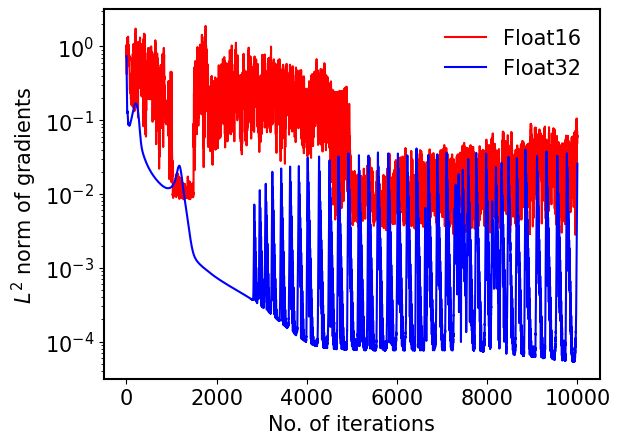

In [7]:
import matplotlib as mpl
mpl.rcParams['font.size'] = 15
#
# process the data
#
cos_similarity_grad = []
grad_mags = []
dist_grad = []

cos_similarity_weights = []
mags_weights = []
dist_weights = []
for (weights16, grads16), (weights32, grads32) in zip(cback16.list_of_weights,cback32.list_of_weights):
    # calculate the metrics for the gradients
    csim, dist = cos_sim_and_dist_of_vectors(grads16, grads32)
    grad_mags.append([np.linalg.norm(grads16), np.linalg.norm(grads32)])
    cos_similarity_grad.append(csim)
    dist_grad.append(dist)
    # calculate the metrics for the weights
    csim, dist = cos_sim_and_dist_of_vectors(weights16, weights32)
    mags_weights.append([np.linalg.norm(weights16), np.linalg.norm(weights32)])
    cos_similarity_weights.append(csim)
    dist_weights.append(dist)
grad_mags = np.array(grad_mags)
mags_weights = np.array(mags_weights)
# do some graphing
epochaxis = np.linspace(0, 10_000, 10_000)
# plot mags_grad (log scale)
# fig, ax = plt.subplots()
# ax.plot(epochaxis, grad_mags[:,0], label="float16")
# ax.plot(epochaxis, grad_mags[:,1], label="float32")
# ax.set_yscale('log')
# ax.set_xscale('log')
# plt.xlabel('Epochs')
# plt.ylabel('Magnitude of gradients of weights (euclidian norm)')
# plt.legend(frameon=False)
# plt.show()
# plot mags_grad
fig, ax = plt.subplots()
ax.plot(epochaxis, grad_mags[:,0],'r', label="Float16")
ax.plot(epochaxis, grad_mags[:,1],'b', label="Float32")
ax.set_yscale('log')
plt.xlabel('No. of iterations')
plt.ylabel('$L^2$ norm of gradients')
plt.legend(frameon=False)
# Set the linewidth of the figure border to 1.5
for axis in ['top', 'bottom', 'left', 'right']:
    plt.gca().spines[axis].set_linewidth(1.5)


plt.savefig("mags1632grads.pdf", format='pdf')
plt.show()

# # plot cos_similarity_grad
# fig, ax = plt.subplots()
# ax.plot(epochaxis, cos_similarity_grad, label="Cosine similarity between gradients of models")
# ax.set_xscale('log')
# plt.xlabel('Epochs')
# plt.ylabel('Cosine similarity between weights vectors')
# plt.legend(frameon=False)
# plt.show()

# # plot dist_grad
# fig, ax = plt.subplots()
# ax.plot(epochaxis, dist_grad, label="Distance between gradients of weights")
# ax.set_xscale('log')
# plt.xlabel('Epochs')
# plt.ylabel('Euclidian distance between gradient vectors')
# plt.legend(frameon=False)
# plt.show()

### we just did the gradients, now do the weights
# print('now the weights')
# # plot mags_grad (log scale)
# fig, ax = plt.subplots()
# ax.plot(epochaxis, mags_weights[:,0], label="Float16")
# ax.plot(epochaxis, mags_weights[:,1], label="Float32")
# ax.set_yscale('log')
# ax.set_xscale('log')
# plt.xlabel('Epochs')
# plt.ylabel('Magnitude of weights (euclidian norm)')
# plt.legend(frameon=False)
# plt.show()
# # plot mags_grad
# fig, ax = plt.subplots()
# ax.plot(epochaxis, mags_weights[:,0], label="Float16")
# ax.plot(epochaxis, mags_weights[:,1], label="Float32")
# ax.set_yscale('log')
# plt.xlabel('Epochs')
# plt.ylabel('Magnitude of weights (euclidian norm)')
# plt.legend(frameon=False)
# plt.show()

# # plot cos_similarity_grad
# fig, ax = plt.subplots()
# ax.plot(epochaxis, cos_similarity_weights, label="Cosine similarity between weights of models")
# ax.set_xscale('log')
# plt.xlabel('Epochs')
# plt.ylabel('Cosine similarity between weights vectors')
# plt.legend(frameon=False)
# plt.show()

# # plot dist_grad
# fig, ax = plt.subplots()
# ax.plot(epochaxis, dist_weights, label="Distance between weights")
# plt.title('Distance between weights')
# ax.set_xscale('log')
# plt.xlabel('Epochs')
# plt.ylabel('Euclidian distance between weight vectors')
# plt.legend(frameon=False)
# plt.show()